In [1]:
import numpy as np
import argparse

In [2]:
parser = argparse.ArgumentParser()
# Data args
parser.add_argument('--dataset_in', type=str, default='MNIST')
parser.add_argument('--n_classes', type=int, default=10)
parser.add_argument('--num_samples', type=int, default=None)

# Model args
parser.add_argument('--model', type=str, default='cnn_3l',
                    choices=['wrn', 'cnn_3l', 'cnn_3l_bn', 'dn'])
parser.add_argument('--conv_expand', type=int, default=1)
parser.add_argument('--fc_expand', type=int, default=1)
parser.add_argument('--depth', type=int, default=28)
parser.add_argument('--width', type=int, default=10)
parser.add_argument('--lr_schedule', type=str, default='linear0')
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--test_batch_size', type=int, default=128)
# parser.add_argument('--learning_rate', type=float, default=0.1)
# parser.add_argument('--weight_decay', type=float, default=2e-4)

# Defense args
parser.add_argument('--is_adv', dest='is_adv', action='store_true')
parser.add_argument('--attack', type=str, default='PGD_l2',
                    choices=['PGD_l2', 'PGD_linf', 'PGD_l2_hybrid_seed', 'PGD_l2_hybrid_replace'])
parser.add_argument('--epsilon', type=float, default=8.0)
parser.add_argument('--attack_iter', type=int, default=10)
parser.add_argument('--gamma', type=float, default=1.0)
parser.add_argument('--eps_step', type=float, default=2.0)
parser.add_argument('--is_dropping', dest='dropping', action='store_true')
parser.add_argument('--rand_init', dest='rand_init', action='store_true')
parser.add_argument('--eps_schedule', type=int, default=0)
parser.add_argument('--num_restarts', type=int, default=1)
parser.add_argument('--marking_strat', type=str, default=None)
parser.add_argument('--matching_path', type=str, default='matchings')
parser.add_argument('--degree_path', type=str, default='graph_data/degree_results')
parser.add_argument("--norm", default='l2', help="norm to be used")
parser.add_argument('--drop_thresh', type=int, default=100)
parser.add_argument('--curriculum', type=str, default='all')

# Attack args
parser.add_argument('--new_attack', type=str, default='PGD_l2',
                    choices=['PGD_l2', 'PGD_linf', 'PGD_l2_hybrid_seed', 'PGD_l2_hybrid_replace'])
parser.add_argument('--new_epsilon', type=float, default=2.0)
parser.add_argument('--new_attack_iter', type=int, default=20)
parser.add_argument('--new_gamma', type=float, default=1.0)
parser.add_argument('--targeted', dest='targeted', action='store_true')
parser.add_argument('--clip_min', type=float, default=0)
parser.add_argument('--clip_max', type=float, default=1.0)
parser.add_argument('--new_rand_init',
                    dest='new_rand_init', action='store_true')
parser.add_argument('--new_num_restarts', type=int, default=1)
parser.add_argument('--new_marking_strat', type=str, default=None)

# IO args
parser.add_argument('--last_epoch', type=int, default=0)
parser.add_argument('--checkpoint_path', type=str,
                    default='trained_models')
parser.add_argument('--is_viz', dest='viz', action='store_true')

# Trial args
parser.add_argument('--num_of_trials', type=int, default=1)
parser.add_argument('--save_test', dest='save_test', action='store_true')
parser.add_argument('--track_hard', dest='track_hard', action='store_true')
parser.add_argument('--trial_num', type=int, default=1)

_StoreAction(option_strings=['--trial_num'], dest='trial_num', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help=None, metavar=None)

In [3]:
eps = 3.8

In [4]:
args = parser.parse_args("--dataset=MNIST --n_classes=2 --num_samples=2000 --model=cnn_3l_bn --attack=PGD_l2 --epsilon={} --attack_iter=50 --gamma=2.5 --new_attack=PGD_l2 --new_epsilon={} --new_attack_iter=50 --new_gamma=2.5 --trial_num=2 --is_adv  --rand_init --new_rand_init".format(eps,eps).split())

In [5]:
args

Namespace(attack='PGD_l2', attack_iter=50, batch_size=128, checkpoint_path='trained_models', clip_max=1.0, clip_min=0, conv_expand=1, curriculum='all', dataset_in='MNIST', degree_path='graph_data/degree_results', depth=28, drop_thresh=100, dropping=False, eps_schedule=0, eps_step=2.0, epsilon=3.8, fc_expand=1, gamma=2.5, is_adv=True, last_epoch=0, lr_schedule='linear0', marking_strat=None, matching_path='matchings', model='cnn_3l_bn', n_classes=2, new_attack='PGD_l2', new_attack_iter=50, new_epsilon=3.8, new_gamma=2.5, new_marking_strat=None, new_num_restarts=1, new_rand_init=True, norm='l2', num_of_trials=1, num_restarts=1, num_samples=2000, rand_init=True, save_test=False, targeted=False, test_batch_size=128, track_hard=False, trial_num=2, viz=False, width=10)

In [21]:
args.eps_step = args.epsilon*args.gamma/args.attack_iter
args.new_eps_step = args.new_epsilon*args.gamma/args.new_attack_iter
attack_params = {'attack': args.new_attack, 'epsilon': args.new_epsilon, 
             'attack_iter': args.new_attack_iter, 'eps_step': args.new_eps_step,
             'targeted': args.targeted, 'clip_min': args.clip_min,
             'clip_max': args.clip_max,'rand_init': args.new_rand_init, 
             'num_restarts': args.new_num_restarts}

In [22]:
args.trial_num

2

In [23]:
class_1 = 3
class_2 = 7
save_file_name = 'logloss_' + str(class_1) + '_' + str(class_2) + '_' + str(args.num_samples) + '_' + args.dataset_in + '_' + args.norm

In [24]:
optimal = np.loadtxt('graph_data/optimal_probs/' + save_file_name + '_' + str(args.epsilon) + '.txt')

In [25]:
optimal

array([[1.     , 0.     ],
       [1.     , 0.     ],
       [1.     , 0.     ],
       ...,
       [0.33333, 0.66667],
       [0.025  , 0.975  ],
       [0.01887, 0.98113]])

In [35]:
from utils.io_utils import model_naming, test_probs_save_name
_, model_name = model_naming(args)
probs_output_fname = test_probs_save_name(args,model_name)

In [36]:
empirical=np.loadtxt(probs_output_fname + '_train_tr{}.txt'.format(args.trial_num))

In [37]:
empirical

array([[0.55539, 0.44461],
       [0.4657 , 0.5343 ],
       [0.88789, 0.11211],
       ...,
       [0.68095, 0.31905],
       [0.16045, 0.83955],
       [0.18921, 0.81079]])

In [38]:
optimal_loss=np.zeros((2*args.num_samples))
optimal_loss[:args.num_samples]=-1*np.log(optimal[:args.num_samples,0])
optimal_loss[args.num_samples:]=-1*np.log(optimal[args.num_samples:,1])

In [39]:
empirical_loss=np.zeros((2*args.num_samples))
empirical_loss[:args.num_samples]=-1*np.log(empirical[:args.num_samples,0])
empirical_loss[args.num_samples:]=-1*np.log(empirical[args.num_samples:,1])

In [40]:
x=np.linspace(0,4,2000)
x

array([0.0000000e+00, 2.0010005e-03, 4.0020010e-03, ..., 3.9959980e+00,
       3.9979990e+00, 4.0000000e+00])

In [41]:
y=np.tile(np.log(2),2000)

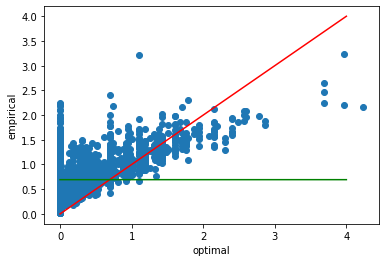

In [42]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# ax.plot(optimal_loss, empirical_loss)

# ax.set(xlabel='optimal', ylabel='empirical',
#        title='optimal vs empirical losses')
# ax.grid()

plt.scatter(optimal_loss, empirical_loss)
plt.xlabel('optimal')
plt.ylabel('empirical')
plt.plot(x,x,color='red')
plt.plot(x,y,color='green')
plt.show()

In [67]:
np.log(2)

0.6931471805599453

In [72]:
np.max(empirical_loss)

2.890471762896498

In [75]:
np.min(empirical[:,1])

0.04019

In [77]:
len(np.unique(optimal_loss))

96

In [78]:
np.unique(optimal_loss)

array([-0.        ,  0.0162615 ,  0.02898607,  0.03539922,  0.08003937,
        0.08338161,  0.08700774,  0.08960747,  0.09531118,  0.10536052,
        0.11778179,  0.13353139,  0.15415401,  0.16705863,  0.18232556,
        0.19004732,  0.1941553 ,  0.20067292,  0.20359831,  0.20763936,
        0.22314355,  0.24512079,  0.2682586 ,  0.28768207,  0.29174364,
        0.31015947,  0.33646624,  0.35402133,  0.35667494,  0.36772145,
        0.37469345,  0.39465871,  0.40546011,  0.43531625,  0.43825693,
        0.44702175,  0.45199084,  0.47956923,  0.48551532,  0.4924783 ,
        0.51082562,  0.51409764,  0.53900222,  0.55961329,  0.57536414,
        0.58777866,  0.6359921 ,  0.66000258,  0.69314718,  0.72742811,
        0.75376805,  0.81094022,  0.82667857,  0.84730119,  0.87546074,
        0.9114027 ,  0.91629073,  0.94445875,  0.95549945,  0.96508715,
        1.01159091,  1.02034654,  1.0360883 ,  1.04145721,  1.09862229,
        1.12058186,  1.16315081,  1.1786625 ,  1.2039728 ,  1.21

In [79]:
np.exp(-1*np.unique(optimal_loss))

array([1.     , 0.98387, 0.97143, 0.96522, 0.92308, 0.92   , 0.91667,
       0.91429, 0.90909, 0.9    , 0.88889, 0.875  , 0.85714, 0.84615,
       0.83333, 0.82692, 0.82353, 0.81818, 0.81579, 0.8125 , 0.8    ,
       0.78261, 0.76471, 0.75   , 0.74696, 0.73333, 0.71429, 0.70186,
       0.7    , 0.69231, 0.6875 , 0.67391, 0.66667, 0.64706, 0.64516,
       0.63953, 0.63636, 0.61905, 0.61538, 0.61111, 0.6    , 0.59804,
       0.58333, 0.57143, 0.5625 , 0.55556, 0.52941, 0.51685, 0.5    ,
       0.48315, 0.47059, 0.44444, 0.4375 , 0.42857, 0.41667, 0.40196,
       0.4    , 0.38889, 0.38462, 0.38095, 0.36364, 0.36047, 0.35484,
       0.35294, 0.33333, 0.32609, 0.3125 , 0.30769, 0.3    , 0.29814,
       0.28571, 0.26667, 0.25304, 0.25   , 0.23529, 0.21739, 0.2    ,
       0.1875 , 0.18421, 0.18182, 0.17647, 0.17308, 0.16667, 0.15385,
       0.14286, 0.125  , 0.11111, 0.1    , 0.09091, 0.08571, 0.08333,
       0.08   , 0.07692, 0.03478, 0.02857, 0.01613])